[-10.0032214  10.0038949 -10.0032227]
[9.9999181 9.9999193 9.9999177]
length of v_meas: 244832
length of v_ref: 244832


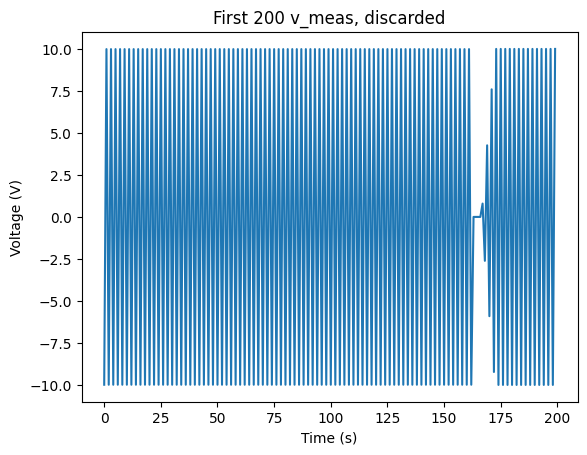

In [17]:
import csv
import matplotlib.pyplot as plt
import numpy as np 

filename = "RECORD_20231114114348.csv"
row_2 = []
row_1 = []

with open(filename, 'r') as file:
  reader = csv.reader(file)
  next(reader) # skip first line
  for row in reader:
    row_2.append(float(row[2]))
    row_1.append(float(row[1]))

# Plot the first 200 v_meas
plt.plot(row_1[:200])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('First 200 v_meas, discarded')

END = 245032

v_ref = np.array(row_2)[200:END]
v_meas = np.array(row_1)[200:END]


OUTLIER_THRESHOLD_PERCENTILE = 5

# Define a function to remove outliers
def remove_outliers(data):
    Q1 = np.percentile(data, OUTLIER_THRESHOLD_PERCENTILE)
    Q3 = np.percentile(data, 100-OUTLIER_THRESHOLD_PERCENTILE)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]


# we use a centered moving average to smooth the data withour introducing a lag
def centered_moving_average(data, window_size):
    """Compute a centered moving average."""
    half_window = window_size // 2
    extended_data = np.pad(data, (half_window, half_window), mode='edge')
    cumsum = np.cumsum(extended_data)
    
    # Subtract the cumulated sum shifted by the window size from the cumulated sum 
    # to get the sum over the window for each point
    sum_window = cumsum[window_size:] - cumsum[:-window_size]
    return sum_window / window_size

# print the first 3 values
print(v_meas[:3])
print(v_ref[:3])

print(f'length of v_meas: {len(v_meas)}')
print(f'length of v_ref: {len(v_ref)}')


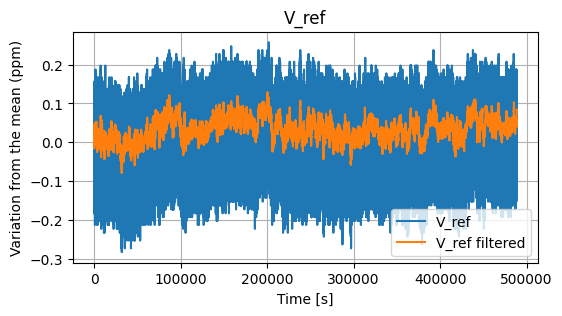

V_ref mean:  9.99991882548768
2 std: 0.17836315541529682
 std filtered: 0.02154652604988546


In [29]:
plt.figure(figsize=(6, 3))

v_ref_ppm = (v_ref - np.mean(v_ref)) * 1e5

CUTOFF = 28000

# time in seconds considering 1 sample = 2 seconds
time_in_seconds = np.arange(0, len(v_ref_ppm[500:]) * 2, 2)

plt.plot(time_in_seconds, v_ref_ppm[500:], label="V_ref")
plt.plot(time_in_seconds, centered_moving_average(v_ref_ppm[500:]-np.mean(v_ref_ppm[500:CUTOFF]), 100), label="V_ref filtered")
plt.title("V_ref")
plt.ylabel("Variation from the mean (ppm)")
plt.xlabel("Time [s]")
plt.grid()
plt.legend(loc="lower right")
plt.savefig("7_v_ref.png", bbox_inches='tight', dpi=300)
plt.show()

print("V_ref mean: ", np.mean(v_ref))

print(f'2 std: {2*np.std(v_ref_ppm)}')
print(f' std filtered: {np.std(centered_moving_average(v_ref_ppm[500:CUTOFF]-np.mean(v_ref_ppm[500:CUTOFF]), 100))}')



[-1.00033033  1.00039756 -1.0003305 ]
[1.0003639479568798, 1.0003640079540466, 1.0003640679694508]
[1.00036395 1.00036401 1.00036407]
[10.00355815, 10.0035588, 10.00355905]


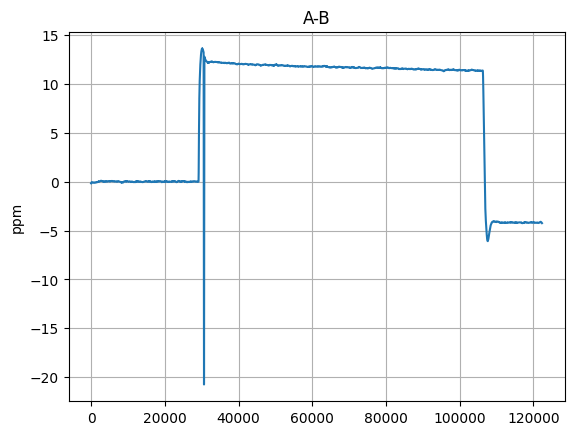

In [22]:
v_meas_calibrated = v_meas / v_ref

# print a sample
print(v_meas_calibrated[:3])

v_meas_calibrated_nooffset = [(-v_meas_calibrated[i] + v_meas_calibrated[i+1])/2 for i in range(0, len(v_meas_calibrated)-1, 2)]

# print a sample
print(v_meas_calibrated_nooffset[:3])

v_meas_calibrated_nooffset_nooutliers = remove_outliers(np.array(v_meas_calibrated_nooffset))
print(v_meas_calibrated_nooffset_nooutliers[:3])

v_meas_ppm_processed = (v_meas_calibrated_nooffset_nooutliers - np.mean(v_meas_calibrated_nooffset_nooutliers[:10000])) * 1e6


v_meas_uncalibrated_nooffset = [(-v_meas[i] + v_meas[i+1])/2 for i in range(0, len(v_meas)-1, 2)]

print(v_meas_uncalibrated_nooffset[:3])

v_meas_uncali_nooff_noout = remove_outliers(np.array(v_meas_uncalibrated_nooffset))

v_meas_uncal_ppm_processed = (v_meas_uncali_nooff_noout - np.mean(v_meas_uncali_nooff_noout[:10000])) * 1e5

plt.plot(centered_moving_average(v_meas_uncal_ppm_processed,100), color='C0')
# plt.plot(centered_moving_average(v_meas_ppm_processed,100), color='C1')
plt.title("A-B")
plt.ylabel("ppm")
plt.grid()
plt.savefig("7_temperature_step_ppm.png", dpi=300)
plt.show()




# write out this data to a file so it can be opened by another script
with open("7_temperature_step_ppm.csv", 'w', newline='') as file:
  writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
  writer.writerow(["uncalibrated", "calibrated"])
  for i in range(len(v_meas_uncal_ppm_processed)):
    writer.writerow([v_meas_uncal_ppm_processed[i], v_meas_ppm_processed[i]])
    

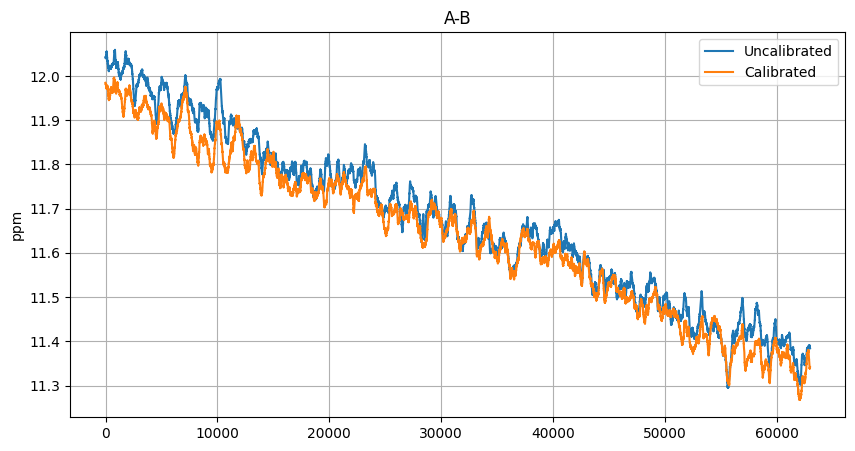

In [23]:
plt.figure(figsize=(10,5))

CUTOFF_START = 40000
CUTOFF_END = 103000

plt.plot(centered_moving_average(v_meas_uncal_ppm_processed[CUTOFF_START:CUTOFF_END],100), color='C0', label="Uncalibrated")
plt.plot(centered_moving_average(v_meas_ppm_processed[CUTOFF_START:CUTOFF_END],100), color='C1', label="Calibrated")
plt.title("A-B")
plt.ylabel("ppm")
plt.legend(loc='upper right')
plt.grid()
plt.savefig("7_temperature_step_ppm.png", dpi=300)
plt.show()

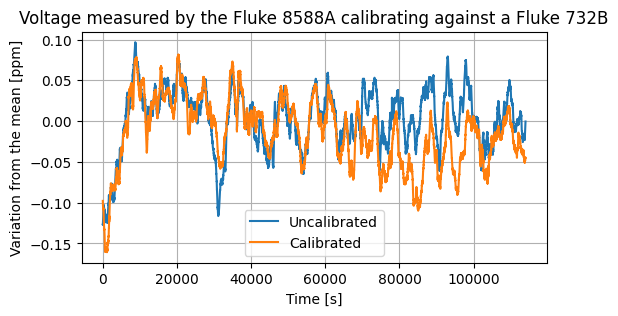

In [28]:

plt.figure(figsize=(6,3))

CUTOFF = 29000

time_in_seconds = np.arange(0, len(v_ref_ppm[500:CUTOFF]) * 4, 4)

plt.plot(time_in_seconds, centered_moving_average(v_meas_uncal_ppm_processed[500:CUTOFF],100), color='C0', label="Uncalibrated")
plt.plot(time_in_seconds, centered_moving_average(v_meas_ppm_processed[500:CUTOFF],100), color='C1', label="Calibrated")
plt.title("Voltage measured by the Fluke 8588A calibrating against a Fluke 732B")
plt.ylabel("Variation from the mean [ppm]")
plt.xlabel("Time [s]")
plt.grid()
plt.legend()
plt.savefig("7_calibrated_vref_before_step_ppm.png", dpi=300, bbox_inches='tight')
plt.show()

